In [ ]:

# ============================================================
# EN3150 Assignment 03 – Task 2: Compare with State-of-the-Art Networks
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import json

# ============================================================
# 1. Load MNIST (UCI equivalent)
# ============================================================
(x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.mnist.load_data()
X_full = np.concatenate([x_train_full, x_test_full], axis=0)
y_full = np.concatenate([y_train_full, y_test_full], axis=0)

# Optional: use subset for Colab memory safety
subset_size = 15000       # use 10k–20k to fit RAM
X_full = X_full[:subset_size]
y_full = y_full[:subset_size]

# ============================================================
# 2. Split dataset 70/15/15
# ============================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y_full, test_size=0.30, random_state=42, stratify=y_full
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# ============================================================
# 3. Preprocessing on-the-fly (memory efficient)
# ============================================================
IMG_SIZE = 224
BATCH = 64

def preprocess_grayscale_to_rgb(x, y):
    x = tf.expand_dims(x, -1)                  # (28,28,1)
    x = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    x = tf.image.grayscale_to_rgb(x)           # (224,224,3)
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(10000)
            .map(preprocess_grayscale_to_rgb, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .map(preprocess_grayscale_to_rgb, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH)
          .prefetch(tf.data.AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
           .map(preprocess_grayscale_to_rgb, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: 10500 Val: 2250 Test: 2250


In [ ]:
# ============================================================
# 4. Custom CNN Model
# ============================================================
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=10,
                     x1=32, x2=64, x3=256, d=0.5):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(x1, (3,3), activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(x2, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(x3, activation='relu')(x)
    x = layers.Dropout(d)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inp, out)

custom_model = build_custom_cnn()
custom_model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
custom_model.summary()

EPOCHS = 20
history_custom = custom_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# ============================================================
# 5. Prepare datasets for ResNet and VGG (preprocessing)
# ============================================================
def map_resnet(x, y):
    return resnet_preprocess(x * 255.0), y

def map_vgg(x, y):
    return vgg_preprocess(x * 255.0), y

train_ds_resnet = train_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)
val_ds_resnet   = val_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)
test_ds_resnet  = test_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)

train_ds_vgg = train_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
val_ds_vgg   = val_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
test_ds_vgg  = test_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,786,186 (98.37 MB)

 Trainable params: 25,786,186 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.7559 - loss: 0.7475 - val_accuracy: 0.9591 - val_loss: 0.1552
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9533 - loss: 0.1617 - val_accuracy: 0.9702 - val_loss: 0.0950
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.9740 - loss: 0.0885 - val_accuracy: 0.9764 - val_loss: 0.0793
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.9783 - loss: 0.0624 - val_accuracy: 0.9791 - val_loss: 0.0747
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9808 - loss: 0.0582 - val_accuracy: 0.9782 - val_loss: 0.0706
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9875 - loss: 0.0390 - val_accuracy: 0.9773 - val_loss: 0.0901
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9884 - loss: 0.0339 - val_accuracy: 0.9796 - val_loss: 0.0846
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9917 - loss: 0

In [ ]:
# ============================================================
# 6. ResNet50 Transfer Learning
# ============================================================
num_classes = 10
base_res = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_res.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_res(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
resnet_model = models.Model(inputs, outputs)

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_resnet_head = resnet_model.fit(train_ds_resnet, validation_data=val_ds_resnet, epochs=8)

# Fine-tune
base_res.trainable = True
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_resnet_ft = resnet_model.fit(train_ds_resnet, validation_data=val_ds_resnet, epochs=12)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 60s 277ms/step - accuracy: 0.6908 - loss: 0.9681 - val_accuracy: 0.9231 - val_loss: 0.2427
Epoch 2/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - accuracy: 0.9086 - loss: 0.2813 - val_accuracy: 0.9658 - val_loss: 0.1190
Epoch 3/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - accuracy: 0.9455 - loss: 0.1723 - val_accuracy: 0.9689 - val_loss: 0.1077
Epoch 4/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.9409 - loss: 0.1887 - val_accuracy: 0.9716 - val_loss: 0.1027
Epoch 5/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.9565 - loss: 0.1373 - val_accuracy: 0.9724 - val_loss: 0.0849
Epoch 6/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.9546 - loss: 0.1370 - val_accuracy: 0.9742 - val_loss: 0.0825
Epoch 7/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.9641 - loss: 0.1115 - val_accuracy: 0.9756 - val_loss: 0.0682
Epoch 8/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# ============================================================
# 7. VGG16 Transfer Learning
# ============================================================
def map_resnet(x, y):
    return resnet_preprocess(x * 255.0), y

def map_vgg(x, y):
    return vgg_preprocess(x * 255.0), y

train_ds_resnet = train_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)
val_ds_resnet   = val_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)
test_ds_resnet  = test_ds.map(map_resnet).prefetch(tf.data.AUTOTUNE)

train_ds_vgg = train_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
val_ds_vgg   = val_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
test_ds_vgg  = test_ds.map(map_vgg).prefetch(tf.data.AUTOTUNE)
num_classes = 10
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_vgg.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_vgg(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
vgg_model = models.Model(inputs, outputs)

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_vgg_head = vgg_model.fit(train_ds_vgg, validation_data=val_ds_vgg, epochs=8)

base_vgg.trainable = True
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_vgg_ft = vgg_model.fit(train_ds_vgg, validation_data=val_ds_vgg, epochs=12)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 90s 400ms/step - accuracy: 0.5816 - loss: 1.6491 - val_accuracy: 0.9467 - val_loss: 0.1962
Epoch 2/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 345ms/step - accuracy: 0.9006 - loss: 0.3209 - val_accuracy: 0.9573 - val_loss: 0.1399
Epoch 3/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 344ms/step - accuracy: 0.9334 - loss: 0.2113 - val_accuracy: 0.9680 - val_loss: 0.1087
Epoch 4/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 343ms/step - accuracy: 0.9518 - loss: 0.1526 - val_accuracy: 0.9720 - val_loss: 0.0985
Epoch 5/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 343ms/step - accuracy: 0.9583 - loss: 0.1385 - val_accuracy: 0.9738 - val_loss: 0.0871
Epoch 6/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 344ms/step - accuracy: 0.9652 - loss: 0.1041 - val_accuracy: 0.9756 - val_loss: 0.0787
Epoch 7/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 344ms/step - accuracy: 0.9740 - loss: 0.0899 - val_accuracy: 0.9729 - val_loss: 0.0862
Epoch 8/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 

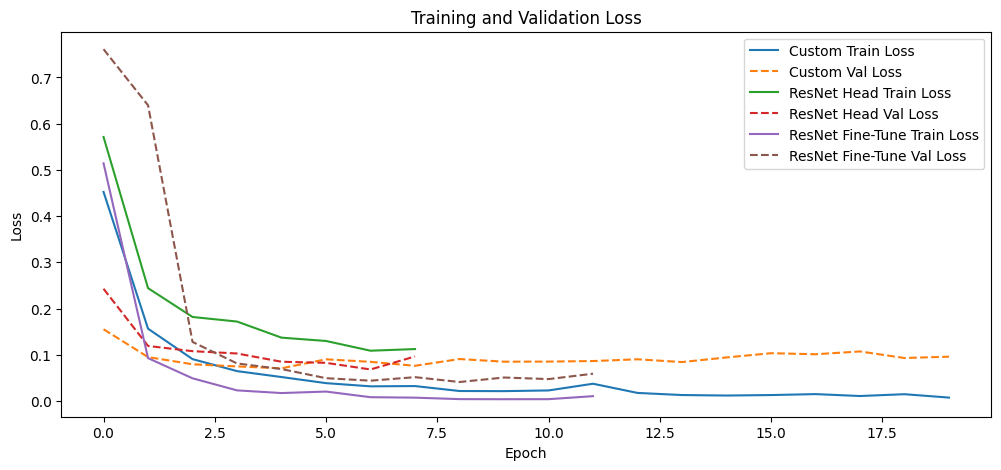

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9799 - loss: 0.1146
Custom CNN Test accuracy: 0.9822221994400024
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.9805 - loss: 0.0679
ResNet50 Test accuracy: 0.9862222075462341
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.9917 - loss: 0.0359
VGG16 Test accuracy: 0.9919999837875366
        Model  Test Accuracy
0  Custom CNN       0.982222
1    ResNet50       0.986222
2       VGG16       0.992000
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

Custom CNN:
               precision    recall  f1-score   support

           0     0.9865    0.9821    0.9843       224
           1     0.9806    0.9961    0.9883       254
           2     0.9686    0.9863    0.9774       219
           3     0.9828    0.9828    0.9828       232
           4     0.9817    0.9773    0.9795       220
           5     0.9948    0.9797    0.9872       197
           6     0.9867    0.9955    0.9911       224
           7     0.9829    0.9623    0.9725 

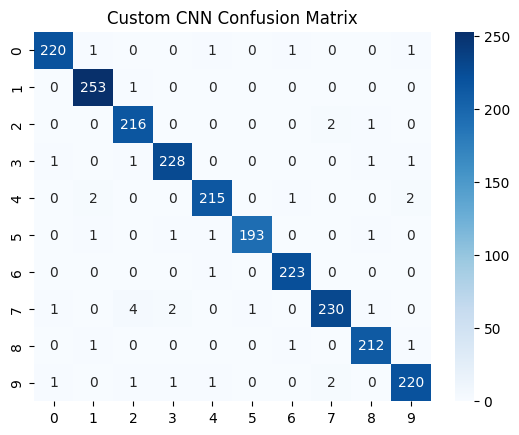

In [ ]:
# ============================================================
# 8. Plot training/validation losses
# ============================================================

def plot_history(histories, titles):
    plt.figure(figsize=(12,5))
    for h, t in zip(histories, titles):
        plt.plot(h.history['loss'], label=f'{t} Train Loss')
        plt.plot(h.history['val_loss'], '--', label=f'{t} Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.title('Training and Validation Loss')
    plt.show()

plot_history([history_custom, history_resnet_head, history_resnet_ft],
             ['Custom', 'ResNet Head', 'ResNet Fine-Tune'])

# ============================================================
# 9. Evaluate and Compare Models
# ============================================================
test_loss_c, test_acc_c = custom_model.evaluate(test_ds)
print("Custom CNN Test accuracy:", test_acc_c)

test_loss_r, test_acc_r = resnet_model.evaluate(test_ds_resnet)
print("ResNet50 Test accuracy:", test_acc_r)

test_loss_v, test_acc_v = vgg_model.evaluate(test_ds_vgg)
print("VGG16 Test accuracy:", test_acc_v)

summary = pd.DataFrame({
    'Model': ['Custom CNN', 'ResNet50', 'VGG16'],
    'Test Accuracy': [test_acc_c, test_acc_r, test_acc_v]
})
print(summary)

# ============================================================
# 10. Classification report & confusion matrix (optional)
# ============================================================
y_true = np.concatenate([y for _, y in test_ds], axis=0)

y_pred_c = np.argmax(custom_model.predict(test_ds), axis=1)
print("\nCustom CNN:\n", classification_report(y_true, y_pred_c, digits=4))
cm_c = confusion_matrix(y_true, y_pred_c)
sns.heatmap(cm_c, annot=True, fmt='d', cmap='Blues')
plt.title('Custom CNN Confusion Matrix'); plt.show()

In [ ]:
# Clone the repo
!git clone https://github.com/Neuro-Matrix-EN3150/Assignment-03-CNN-for-image-classification.git

# Change into repo folder
%cd Assignment-03-CNN-for-image-classification

# Copy your notebook
!cp /content/YourNotebook.ipynb .

# Configure Git
!git config --global user.email "jatheess478@gmail.com"
!git config --global user.name "Jathees"

# Add & commit
!git add .
!git commit -m "Add Colab notebook for assignment 03"

# Push to GitHub
!git push https://<Jathees985>:<YOUR_PERSONAL_ACCESS_TOKEN>@github.com/Neuro-Matrix-EN3150/Assignment-03-CNN-for-image-classification.git


Cloning into 'Assignment-03-CNN-for-image-classification'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), done.
/content/Assignment-03-CNN-for-image-classification/Assignment-03-CNN-for-image-classification
cp: cannot stat '/content/YourNotebook.ipynb': No such file or directory
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
/bin/bash: line 1: Jathees985: No such file or directory
